# Visualization of Trained Model Results

This notebook provides visualizations and analysis for the outputs of trained models, including performance metrics, plots, confusion matrices, feature importances, and interactive figures to explore results.

1) Register existing envionment as a jupyter kernel **(Do this once within the activated virtual environment in the terminal)** \
`python -m ipykernel install --user --name project-venv --display-name "Python (Project Env)"`

2) Start Jupyter Notebook From Same Environment \
`python -m jupyter notebook`

### Troubleshooting

Code for troubleshooting environment settings or any misc settings

In [1]:
# import sys
# print(sys.executable)

### Required Libraries

Install & Import Required Libraries That Will Be Utilized Throughout The Notebook In The Virtual Environment.

In [2]:
### Plotting / Graphing Libraries
import matplotlib.pyplot as plt
import seaborn as sns

### Image Visualization Libraries
import cv2
from PIL import Image
import numpy as np

### Image Processing Libraries
from skimage import measure, morphology
from skimage.color import label2rgb

### Anomaly Map Visualization Libraries
from matplotlib import cm

### Metrics Libraries
from sklearn.metrics import roc_curve, precision_recall_curve, auc, f1_score, confusion_matrix

### Misc Libraries
import plotly.express as px
import plotly.graph_objects as goz

## Visualizing Dataset
**MIIC** is a novel dataset of real microscopic images of integrated circuits (ICs), to benchmark the IAD algorithms. The MIIC dataset includes 25,160 normal and 116 anomalous high-resolution IC images obtained by ScanningElectron Microscopy (SEM). The SEM images are taken at the metal layer of a manufactured IC and are in gray-scale with a dimension of 512x512 pixels. For each image containing anomalies, we provide differ-ent types of annotations, including the bounding box and pixel-wise ground truth mask for them, which enables future research toward various computer vision applications.

#### Original Training Images
Sample displays of "non-anomalous" images used in the training for the DSR model.

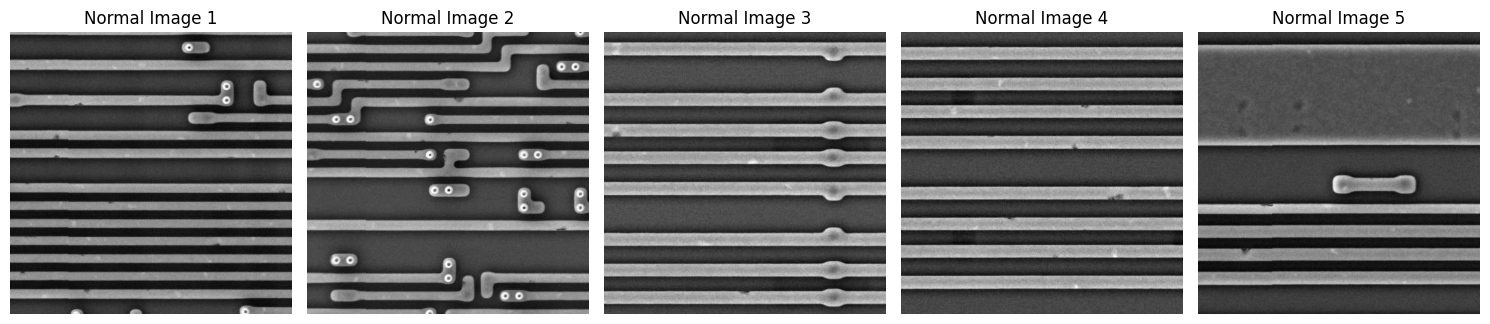

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

normal_image_paths = [
    "../data/train/normal/train_normal_04501.jpg",
    "../data/train/normal/train_normal_04541.jpg",
    "../data/train/normal/train_normal_04851.jpg",
    "../data/train/normal/train_normal_04918.jpg",
    "../data/train/normal/train_normal_05154.jpg",
]

images = [np.array(Image.open(p)) for p in normal_image_paths]

plt.figure(figsize=(15, 4))

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i], cmap="gray")
    plt.title(f"Normal Image {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()


#### Non-anomalous Images
Sample displays of "anomalous" images that the DSR model should flag out

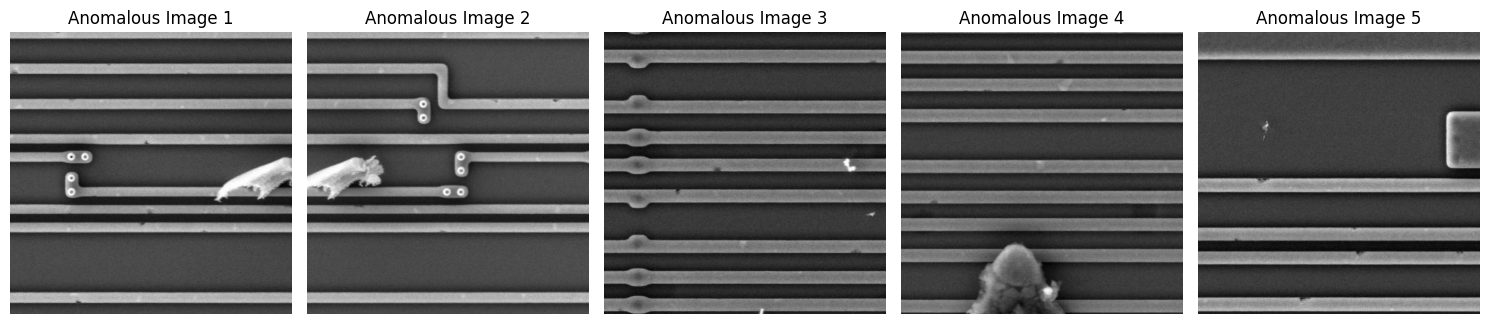

In [4]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

anomalous_image_paths = [
    "../data/test/anomalous/test_abnormal_00029.jpg",
    "../data/test/anomalous/test_abnormal_00042.jpg",
    "../data/test/anomalous/test_abnormal_00072.jpg",
    "../data/test/anomalous/test_abnormal_00009.jpg",
    "../data/test/anomalous/test_abnormal_00109.jpg",
]

images = [np.array(Image.open(p)) for p in anomalous_image_paths]

plt.figure(figsize=(15, 4))

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i], cmap="gray")
    plt.title(f"Anomalous Image {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

## DSR Model Results (General Semicon Images Trained Model)
Taking in a small sample size *(~10 images)*, display performance and sample results of anomalous and non-anomalous images passing through the trained DSR model


#### Sample Image Inputs
Equal mix of anomalous and non-anomalous images to be passed into the model


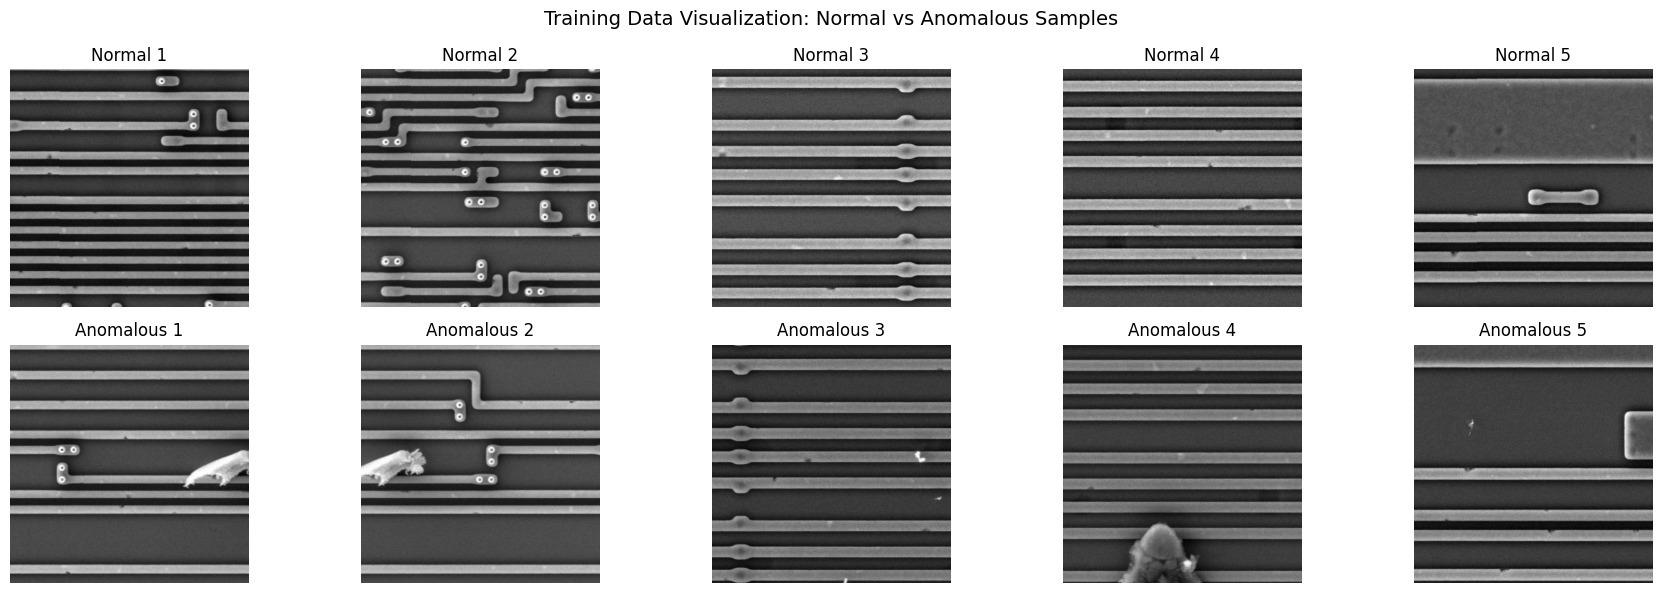

In [5]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Image Paths
anomalous_image_paths = [
    "../data/test/anomalous/test_abnormal_00029.jpg",
    "../data/test/anomalous/test_abnormal_00042.jpg",
    "../data/test/anomalous/test_abnormal_00072.jpg",
    "../data/test/anomalous/test_abnormal_00009.jpg",
    "../data/test/anomalous/test_abnormal_00109.jpg",
]

normal_image_paths = [
    "../data/train/normal/train_normal_04501.jpg",
    "../data/train/normal/train_normal_04541.jpg",
    "../data/train/normal/train_normal_04851.jpg",
    "../data/train/normal/train_normal_04918.jpg",
    "../data/train/normal/train_normal_05154.jpg",
]

# Load images
normal_images = [np.array(Image.open(p)) for p in normal_image_paths]
anomalous_images = [np.array(Image.open(p)) for p in anomalous_image_paths]

# Create a 2x5 grid
plt.figure(figsize=(18, 6))

# First row: Normal images
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(normal_images[i], cmap="gray")
    plt.title(f"Normal {i+1}")
    plt.axis("off")

# Second row: Anomalous images
for i in range(5):
    plt.subplot(2, 5, i + 6)   # +6 because second row starts at position 6
    plt.imshow(anomalous_images[i], cmap="gray")
    plt.title(f"Anomalous {i+1}")
    plt.axis("off")

plt.suptitle("Training Data Visualization: Normal vs Anomalous Samples", fontsize=14)
plt.tight_layout()
plt.show()


#### Create Custom Dataset For Testing

In [6]:
import os, shutil

selected_image_paths = normal_image_paths + anomalous_image_paths

tmp_dir = "../data/temp_infer/images"
os.makedirs(tmp_dir, exist_ok=True)

# (Optional) clear old files
for f in os.listdir(tmp_dir):
    os.remove(os.path.join(tmp_dir, f))

# copy in selected images
for p in selected_image_paths:
    shutil.copy(p, os.path.join(tmp_dir, os.path.basename(p)))



In [7]:
import sys, pandas as pd
import torch
print("python:", sys.executable)
print("torch:", torch.__version__)
print("torch.version.cuda:", torch.version.cuda)
print("cuda available:", torch.cuda.is_available())
print("python:", sys.executable)
print("pandas:", pd.__version__)


python: c:\Users\luoma\Documents\FYP\Encoder-Decoder\venv\Scripts\python.exe
torch: 2.5.1+cu121
torch.version.cuda: 12.1
cuda available: True
python: c:\Users\luoma\Documents\FYP\Encoder-Decoder\venv\Scripts\python.exe
pandas: 2.3.3


#### Run Inference & Visualize Results
- Load in trained model
- Predict selected images

In [17]:
# ------------------------ IMPORTS --------------------------------
from anomalib.data import Folder
from anomalib.models import Dsr
from anomalib.engine import Engine
import glob, os
import torch

# ------------------------ LOAD CONFIGS --------------------------------
MODEL_PATH = "../weights/dsr_semicon_epoch=53.ckpt"

# ---- Ensure GPU Used When Available ----
# if torch.cuda.is_available():
#     torch.cuda.set_device(0)  # Set to the first GPU if available

# --- load trained model ---
model = Dsr.load_from_checkpoint(
    MODEL_PATH,
)

# --- create engine for testing ---
engine = Engine(
    logger = True,  # enable logging
    accelerator="gpu",  # use available accelerator (GPU/CPU)
    log_every_n_steps=10,
)

datamodule = Folder(
    name="temp_infer",
    root="../data/temp_infer",
    normal_dir="images",   # required argument
    normal_test_dir="images",
    abnormal_dir="images",
    val_split_mode="none",
    test_split_mode="none",
    eval_batch_size=1,
)

# Check if intended directory contains images
img_dir = "../data/temp_infer/test/normal"
files = sorted(glob.glob(os.path.join(img_dir, "*.*")))
print("Found", len(files), "files")
print(files[:5])

preds = engine.predict(model=model, datamodule=datamodule, ckpt_path=MODEL_PATH)
# print(preds[0].keys())

c:\Users\luoma\Documents\FYP\Encoder-Decoder\venv\Lib\site-packages\lightning\pytorch\utilities\migration\utils.py:56: The loaded checkpoint was produced with Lightning v2.6.0, which is newer than your current Lightning version: v2.5.5
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at C:\Users\luoma\Documents\FYP\Encoder-Decoder\weights\dsr_semicon_epoch=53.ckpt


Found 10 files
['../data/temp_infer/test/normal\\test_abnormal_00009.jpg', '../data/temp_infer/test/normal\\test_abnormal_00029.jpg', '../data/temp_infer/test/normal\\test_abnormal_00042.jpg', '../data/temp_infer/test/normal\\test_abnormal_00072.jpg', '../data/temp_infer/test/normal\\test_abnormal_00109.jpg']


c:\Users\luoma\Documents\FYP\Encoder-Decoder\venv\Lib\site-packages\lightning\pytorch\utilities\migration\utils.py:56: The loaded checkpoint was produced with Lightning v2.6.0, which is newer than your current Lightning version: v2.5.5
c:\Users\luoma\Documents\FYP\Encoder-Decoder\venv\Lib\site-packages\lightning\pytorch\trainer\call.py:283: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': 'train_loss_epoch', 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 3, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at C:\Users\luoma\Documents\FYP\Encoder-Decoder\weights\dsr_semicon_epoch=53.ckpt
c:\Users\luoma\Documents\FYP\Encoder-Decoder\venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_

Predicting: |          | 0/? [00:00<?, ?it/s]

In [18]:
image_number = 7  # Change this index to view different images from the batch
# print(preds)
print(preds[image_number].keys())
print(preds[image_number]['image_path'])
print(preds[image_number]['gt_label'])
print(preds[image_number]['pred_score'])

['image', 'gt_label', 'gt_mask', 'mask_path', 'anomaly_map', 'pred_score', 'pred_mask', 'pred_label', 'explanation', 'image_path']
['C:\\Users\\luoma\\Documents\\FYP\\Encoder-Decoder\\data\\temp_infer\\images\\train_normal_04851.jpg']
tensor([True])
tensor([nan])


#### Display anomalous & non-anomalous results
Load original image, as well as the anomaly map results and the final overlay

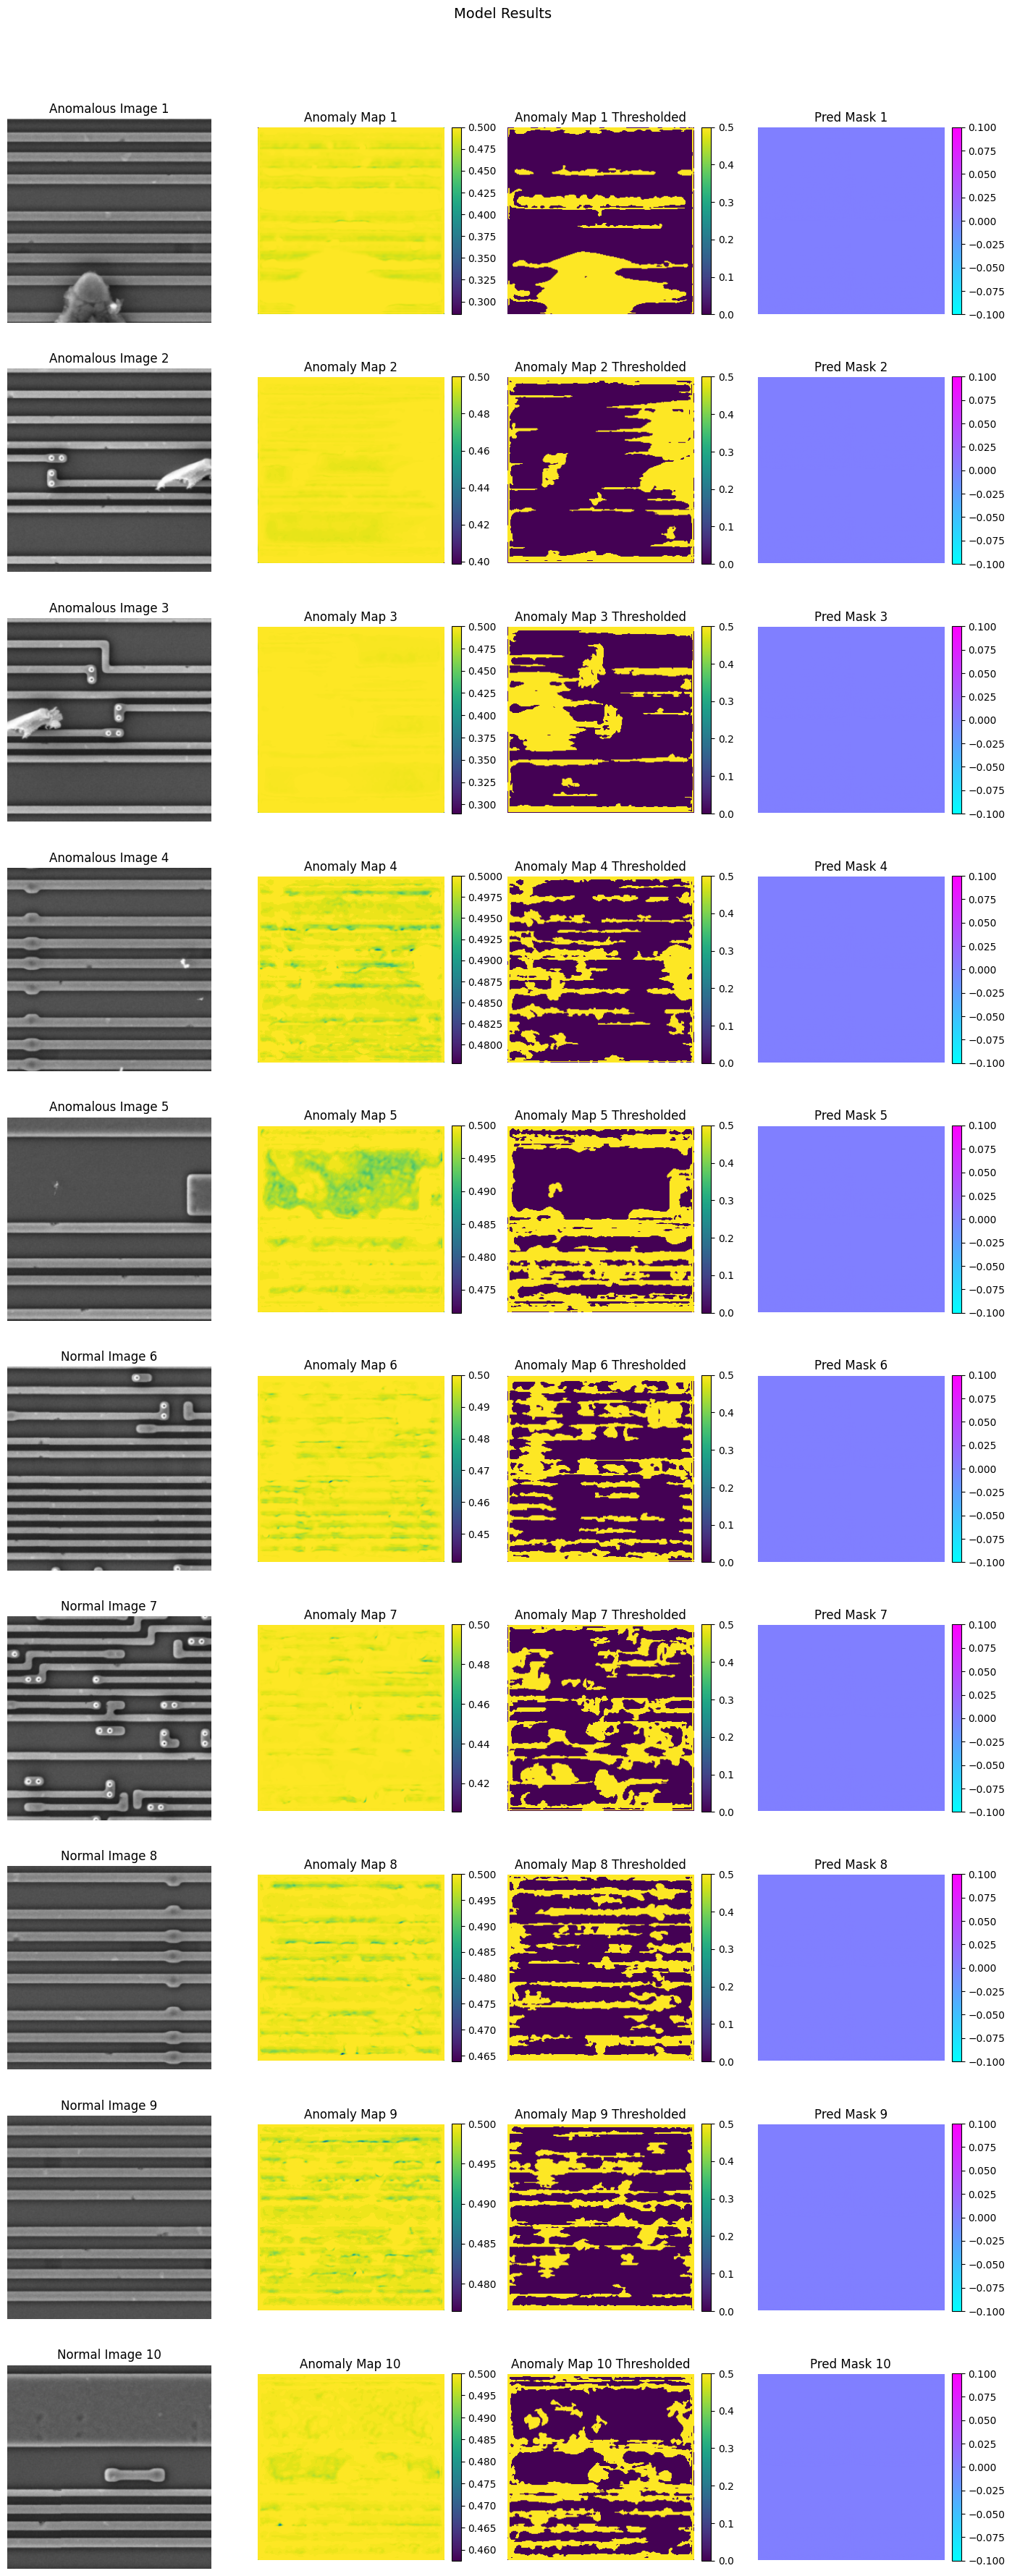

In [33]:
import numpy as np
from skimage import morphology
import matplotlib.pyplot as plt

def fetch(pred, key):
    # Try dict-style first
    if hasattr(pred, "__getitem__"):
        try:
            return pred[key]
        except Exception:
            pass
    # Then attribute-style
    return getattr(pred, key, None)

def to_imshow(x, idx=0, is_mask=False):
    if x is None:
        return None

    # torch -> cpu numpy
    if hasattr(x, "detach"):
        x = x.detach().cpu().numpy()
    else:
        x = np.array(x)

    # If batched (B,C,H,W) take one
    if x.ndim == 4:
        x = x[idx]  # -> (C,H,W)
    # If batched mask/map (B,H,W)
    elif x.ndim == 3 and x.shape[0] != x.shape[-1] and x.shape[0] != x.shape[1]:
        x = x[idx]

    # CHW -> HWC
    if x.ndim == 3 and x.shape[0] in (1, 3, 4):
        x = np.transpose(x, (1, 2, 0))

    if is_mask:
        if x.ndim == 3:
            x = x[..., 0]
        x = x.squeeze()

    return x

def anomalyMapFilter(anomaly_map, threshold=0.5, min_size=100):
    """
    anomaly_map: numpy array (H, W) or (H, W, 1)
    threshold: float
    min_size: minimum connected component size to keep

    Returns:
        filtered anomaly map
    """
    # Ensure 2D
    if anomaly_map.ndim == 3:
        anomaly_map = anomaly_map.squeeze()

    # Step 1: threshold → binary mask
    binary_map = anomaly_map > threshold

    # Step 2: remove small noisy regions
    cleaned_mask = morphology.remove_small_objects(binary_map, min_size=min_size)

    # Step 3: apply mask to original anomaly map
    filtered_map = anomaly_map.copy()
    filtered_map[~cleaned_mask] = 0.0   # lowest possible value

    return filtered_map, cleaned_mask

def plot_prediction(preds, idx=0):
    no_of_predictions = len(preds)

    # Create N rows, 3 columns
    fig, axes = plt.subplots(no_of_predictions, 4, figsize=(14, 3.5 * no_of_predictions))

    # If only 1 prediction, axes is 1D, make it 2D
    if no_of_predictions == 1:
        axes = np.array([axes])

    for i in range(no_of_predictions):
        image     = to_imshow(fetch(preds[i], "image"), idx=idx, is_mask=False)
        anomaly   = to_imshow(fetch(preds[i], "anomaly_map"), idx=idx, is_mask=True)
        pred_mask = to_imshow(fetch(preds[i], "pred_mask"), idx=idx, is_mask=True)

        # Check if image is anomalous or not
        header_prefix = "Anomalous" if "_abnormal_" in preds[i]['image_path'][0] else "Normal"

        # ---- Column 1: Image ----
        ax = axes[i, 0]
        if image is None:
            ax.text(0.5, 0.5, "image=None", ha="center", va="center")
        else:
            if image.ndim == 2:
                ax.imshow(image, cmap="gray")
            else:
                ax.imshow(image)
        ax.set_title(f"{header_prefix} Image {i+1}")
        ax.axis("off")

        # ---- Column 2: Anomaly Map ----
        ax = axes[i, 1]
        if anomaly is None:
            ax.text(0.5, 0.5, "anomaly_map=None", ha="center", va="center")
        else:
            im = ax.imshow(anomaly, cmap="viridis")
            fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        ax.set_title(f"Anomaly Map {i+1}")
        ax.axis("off")

        # ---- Column 3 Anomaly Map Thresholded----
        ax = axes[i, 2]
        if anomaly is None:
            ax.text(0.5, 0.5, "anomaly_map=None", ha="center", va="center")
        else:
            filtered_anomaly, pred_maskz = anomalyMapFilter(anomaly, threshold=0.4999999, min_size=150)
            im = ax.imshow(filtered_anomaly, cmap="viridis")
            fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        ax.set_title(f"Anomaly Map {i+1} Thresholded")
        ax.axis("off")

        # ---- Column 4: Pred Mask ----
        ax = axes[i, 3]
        if pred_mask is None:
            ax.text(0.5, 0.5, "pred_mask=None", ha="center", va="center")
        else:
            im = ax.imshow(pred_mask, cmap="cool")
            fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        ax.set_title(f"Pred Mask {i+1}")
        ax.axis("off")

    plt.suptitle("Model Results", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

plot_prediction(preds, idx=0)

### Results Metrics Display
Taking in the 116 **Anomalous** test images, & 1272 **Normal** test images, we shall compute some image level and pixel level metrics.

Testing Dataset Breakdown

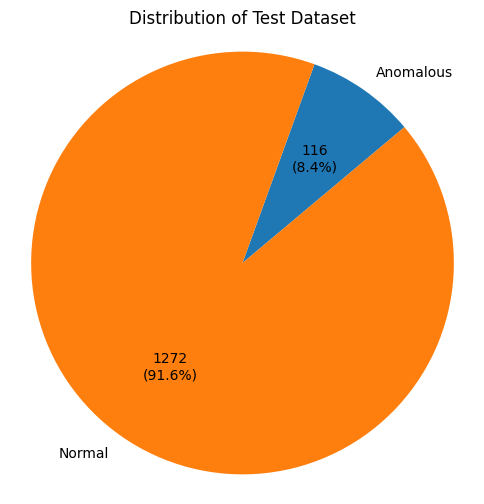

(1272, 116)

In [41]:
import os
import matplotlib.pyplot as plt

# Paths
normal_path = "../data/test/normal"
anomalous_path = "../data/test/anomalous"

# Count image files (common image extensions)
image_exts = (".png", ".jpg", ".jpeg", ".bmp", ".tiff", ".tif")

normal_count = len([f for f in os.listdir(normal_path) if f.lower().endswith(image_exts)])
anomalous_count = len([f for f in os.listdir(anomalous_path) if f.lower().endswith(image_exts)])

# Data for pie chart
labels = ["Anomalous", "Normal"]
sizes = [anomalous_count,normal_count]

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        count = int(round(pct * total / 100.0))
        return f"{count}\n({pct:.1f}%)"
    return my_autopct

# Plot pie chart (no colors specified as instructed)
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct=make_autopct(sizes), startangle=40)
plt.title("Distribution of Test Dataset")
plt.axis("equal")
plt.show()

normal_count, anomalous_count


Testing Datamodule Configurations

In [ ]:
import torch
from anomalib.data import Folder
from anomalib.data.utils import TestSplitMode, ValSplitMode
from anomalib.engine import Engine
from anomalib.metrics import AUROC, F1Score, Evaluator, AUPR
from anomalib.models.image.dsr import Dsr

DATA_ROOT = "../data"
CKPT_PATH = "../weights/dsr_semicon_epoch=53.ckpt"

# 1) Data (train normals only; test has normal + anomalous)
dm = Folder(
    name="semicon_dsr",
    root=DATA_ROOT,
    normal_dir="train/normal",
    normal_test_dir="test/normal",
    abnormal_dir="test/anomalous",
    test_split_mode=TestSplitMode.FROM_DIR,
    val_split_mode=ValSplitMode.FROM_TEST,
    eval_batch_size=8,
    num_workers=4,
)

# 2) Metrics for TEST
# AUROC uses continuous anomaly score
auroc = AUROC(fields=["pred_score", "gt_label"], prefix="image_")
aupr  = AUPR(fields=["pred_score", "gt_label"], prefix="image_")
# F1 uses binary pred_label (depends on thresholding/post-processing inside model)
f1 = F1Score(fields=["pred_label", "gt_label"], prefix="image_")

evaluator = Evaluator(test_metrics=[auroc, aupr])

# 3) Load model with evaluator
model = Dsr.load_from_checkpoint(CKPT_PATH, evaluator=evaluator)


c:\Users\luoma\Documents\FYP\Encoder-Decoder\venv\Lib\site-packages\lightning\pytorch\utilities\migration\utils.py:56: The loaded checkpoint was produced with Lightning v2.6.0, which is newer than your current Lightning version: v2.5.5
c:\Users\luoma\Documents\FYP\Encoder-Decoder\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'evaluator' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['evaluator'])`.


#### Image Level Metrics
**AUROC (Image-Level):** \
Evaluates how well your model separates normal and anomalous samples, across all thresholds.
$$
AUROC = P(score\_anomaly > score\_normal)
$$
Interpretation : Probability that a *random anomalous sample* has a higher anomaly score than a *random normal sample

⚙️ **Computation :**
1) For every possible threshold $t \in [0, 1]$
	- **TPR** *(True Positive Rate)* = $TP / (TP + FN)$
	- **FPR** *(False Positive Rate)* = $FP / (FP + TN)$
2) Plot TPR vs FPR
3) Compute **area under ROC Curve**
---
**AUPR (Image-Level):** \
AUPR focuses on positive-class quality *(how precisely & completely your model identifies anomalies)*
$$
\begin{align*}
&Precision = TP / (TP + FP) \\\\
&Recall = TP / (TP + FN)
\end{align*}
$$

⚙️ **Computation :**
1. Sweep the decision threshold from 0 → 1.
    
2. For each threshold, compute (Precision, Recall).
    
3. Plot Precision vs Recall curve.
    
4. Integrate area under it → AUPR.

---
**F1-Score**:\
Measures how well a model balances correctly detecting positives while avoiding mistakenly identifying positives at a **single decision threshold.**

Convert Model Scores Into Binary Predictions At A Specific Threshold $t$
$$
\hat{y} = 
\begin{cases}
1 & \text{if } \text{score} \ge t \\
0 & \text{otherwise } 
\end{cases}
$$

Compute F1-Score
$$
\text{F1-Score} = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}
$$


In [75]:
# Run tests
engine = Engine(accelerator="gpu", devices=1, logger=True, default_root_dir="results", log_every_n_steps=10,)
results = engine.test(model=model, datamodule=dm)

print(results)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\luoma\Documents\FYP\Encoder-Decoder\venv\Lib\site-packages\lightning\pytorch\core\saving.py:363: Skipping 'evaluator' parameter because it is not possible to safely dump to YAML.
c:\Users\luoma\Documents\FYP\Encoder-Decoder\venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUPR         │    0.9920997619628906     │
│        image_AUROC        │    0.9999999403953552     │
│       image_F1Score       │            0.0            │
└───────────────────────────┴───────────────────────────┘

[{'image_AUROC': 0.9999999403953552, 'image_AUPR': 0.9920997619628906, 'image_F1Score': 0.0}]


#### Prediction Score Distribution
Model successfully separates normal vs anomalous images if their score distributions barely overlap.
$$
\text{Anomaly\_Score} = \frac{1}{H*W}\sum{\text{anomaly\_map(x, y)}}
$$
Take mean of anomaly map as image level score since **ground truth mask** is non-existent, thus preventing pred_score to be formed from pred_mask

In [64]:
# Analyze prediction scores distribution
preds = engine.predict(model=model, datamodule=dm)


ckpt_path is not provided. Model weights will not be loaded.
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, ImageVisualizer, PostProcessor, PreProcessor
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\luoma\Documents\FYP\Encoder-Decoder\venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [78]:
print(preds[0].pred_score)
print(preds[0].pred_mask)

tensor([nan, nan, nan, nan, nan, nan, nan, nan])
Mask([[[False, False, False,  ..., False, False, False],
       [False, False, False,  ..., False, False, False],
       [False, False, False,  ..., False, False, False],
       ...,
       [False, False, False,  ..., False, False, False],
       [False, False, False,  ..., False, False, False],
       [False, False, False,  ..., False, False, False]],

      [[False, False, False,  ..., False, False, False],
       [False, False, False,  ..., False, False, False],
       [False, False, False,  ..., False, False, False],
       ...,
       [False, False, False,  ..., False, False, False],
       [False, False, False,  ..., False, False, False],
       [False, False, False,  ..., False, False, False]],

      [[False, False, False,  ..., False, False, False],
       [False, False, False,  ..., False, False, False],
       [False, False, False,  ..., False, False, False],
       ...,
       [False, False, False,  ..., False, False, False],

In [73]:
import torch
import numpy as np

scores = []
labels = []

for p in preds:
    # anomaly_map shape: [B, H, W] or [H, W]
    am = p.anomaly_map.detach().cpu()

    # Take mean of top 1% anomalous pixels in map as anomaly score
    # k = int(0.01 * am.numel())  # top 1%
    # topk = torch.topk(am.view(-1), k).values
    # score = topk.mean().item()

    # Take mean of entire anomaly map as anomaly score
    score = am.mean().item()


    # gt_label is batched, so flatten and take first
    gt = p.gt_label.detach().cpu().to(torch.int).view(-1)[0].item()

    scores.append(float(score))
    labels.append(int(gt))

scores = np.array(scores)
labels = np.array(labels)

print("Total samples:", len(scores))
print("Unique labels:", set(labels))

scores_norm = scores[labels == 0]
scores_anom = scores[labels == 1]

print("Normal score range:", scores_norm.min(), "→", scores_norm.max())
print("Anomalous score range:", scores_anom.min(), "→", scores_anom.max())


Total samples: 87
Unique labels: {np.int64(0), np.int64(1)}
Normal score range: 0.49871402978897095 → 0.499281108379364
Anomalous score range: 0.4972035586833954 → 0.4986830949783325


Visualize Anomaly Score Distribution

C:\Users\luoma\AppData\Local\Temp\ipykernel_22320\129063726.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([scores_norm, scores_anom], labels=["Normal", "Anomalous"])


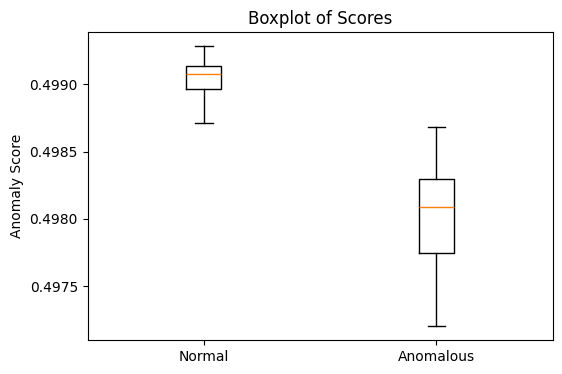

In [81]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.boxplot([scores_norm, scores_anom], labels=["Normal", "Anomalous"])
plt.ylabel("Anomaly Score")
plt.title("Boxplot of Scores")
plt.show()
